# Home Pricing Regression Model Creation and Deployment

In this notebook we will create some simple regression models on a home value dataset and deploy them for monitoring on watsonx.governance.

In [ ]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the California Housing dataset
housing = fetch_california_housing()
print(housing['DESCR'])
X, y = housing.data, housing.target

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate and print results
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name} Results:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared Score: {r2:.2f}")
    return y_pred

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = evaluate_model(lr_model, X_test_scaled, y_test, "Linear Regression")

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")




Linear Regression Results:
Mean Squared Error: 0.56
R-squared Score: 0.58

Random Forest Results:
Mean Squared Error: 0.26
R-squared Score: 0.81


In [ ]:
# Print Linear Regression coefficients
print("\nLinear Regression Coefficients:")
for name, coef in zip(housing.feature_names, lr_model.coef_):
    print(f"{name}: {coef:.4f}")

# Print Random Forest feature importances
print("\nRandom Forest Feature Importances:")
for name, importance in zip(housing.feature_names, rf_model.feature_importances_):
    print(f"{name}: {importance:.4f}")

# Example prediction
sample_house = X_test_scaled[0].reshape(1, -1)
lr_prediction = lr_model.predict(sample_house)[0]
rf_prediction = rf_model.predict(sample_house)[0]
print(f"\nSample house predictions:")
print(f"Linear Regression: ${lr_prediction * 100000:.2f}")
print(f"Random Forest: ${rf_prediction * 100000:.2f}")


Linear Regression Coefficients:
MedInc: 0.8544
HouseAge: 0.1225
AveRooms: -0.2944
AveBedrms: 0.3393
Population: -0.0023
AveOccup: -0.0408
Latitude: -0.8969
Longitude: -0.8698

Random Forest Feature Importances:
MedInc: 0.5249
HouseAge: 0.0546
AveRooms: 0.0443
AveBedrms: 0.0296
Population: 0.0306
AveOccup: 0.1384
Latitude: 0.0889
Longitude: 0.0886

Sample house predictions:
Linear Regression: $71912.28
Random Forest: $50950.00


Let's create some plots so we know how to set some of our monitoring thresholds.

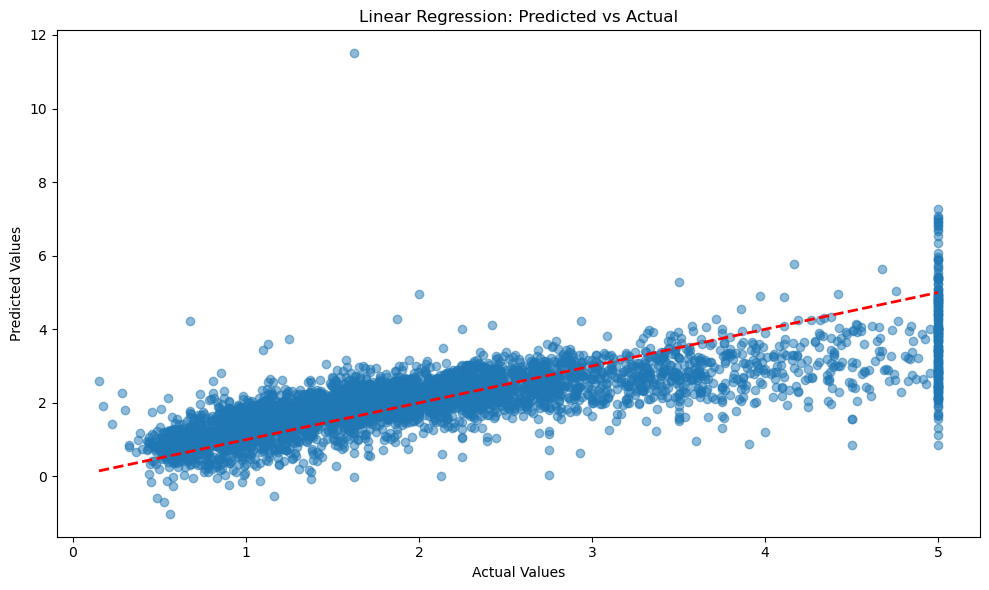

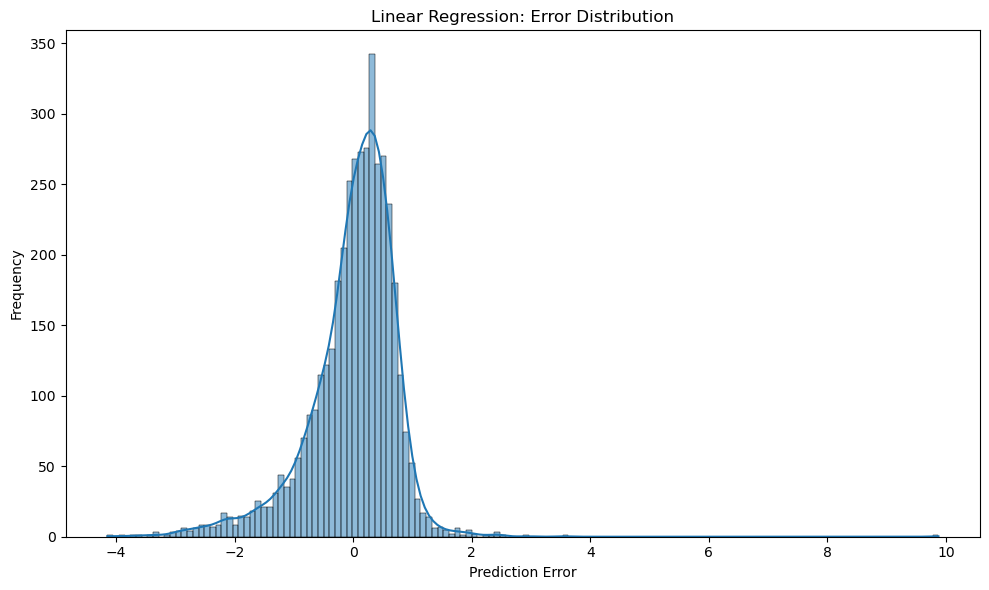

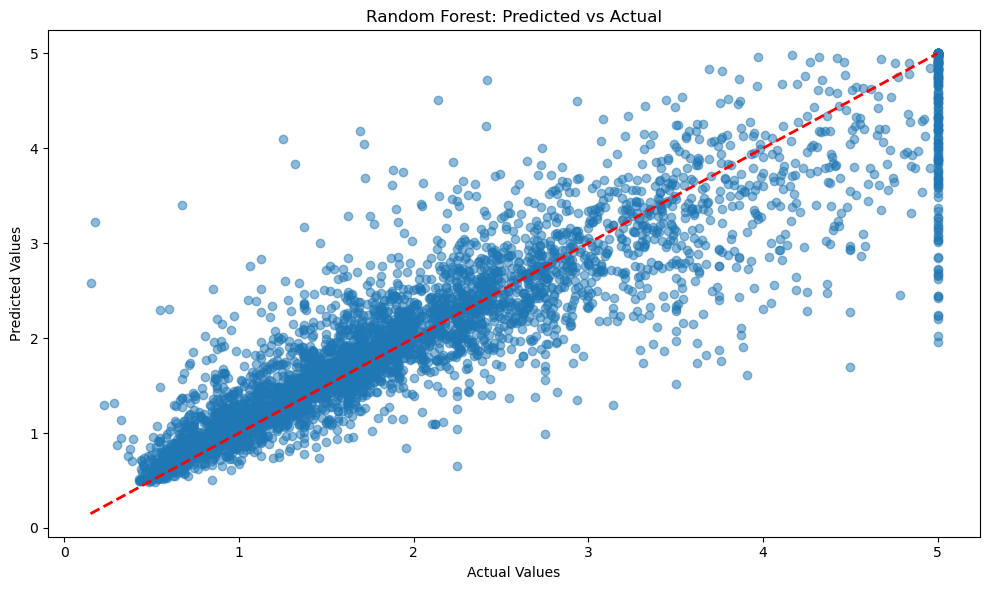

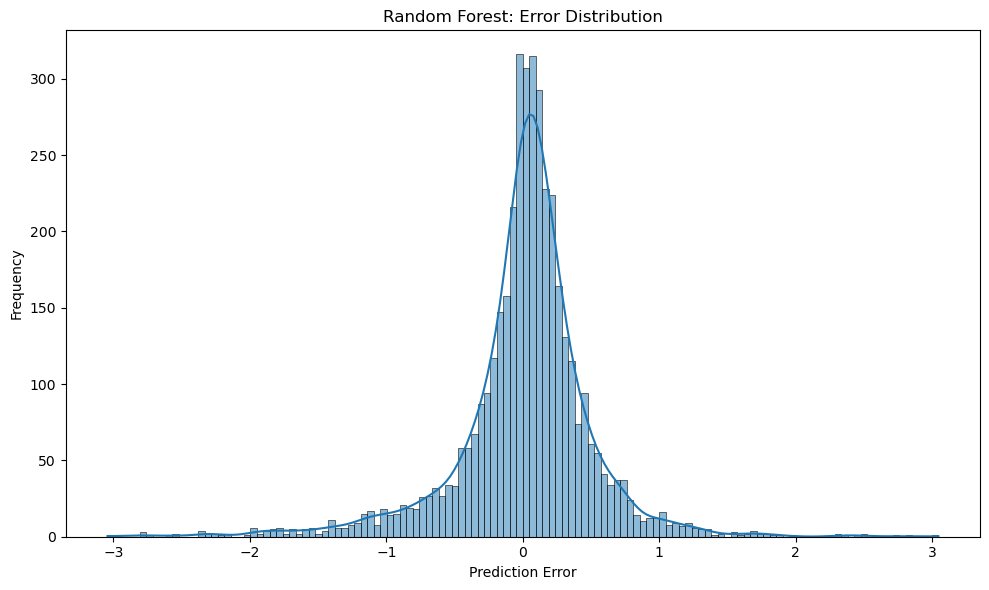

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_prediction_vs_actual(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Create a function to plot prediction error distribution
def plot_error_distribution(y_true, y_pred, title):
    errors = y_pred - y_true
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot for Linear Regression
plot_prediction_vs_actual(y_test, lr_pred, 'Linear Regression: Predicted vs Actual')
plot_error_distribution(y_test, lr_pred, 'Linear Regression: Error Distribution')

# Plot for Random Forest
plot_prediction_vs_actual(y_test, rf_pred, 'Random Forest: Predicted vs Actual')
plot_error_distribution(y_test, rf_pred, 'Random Forest: Error Distribution')


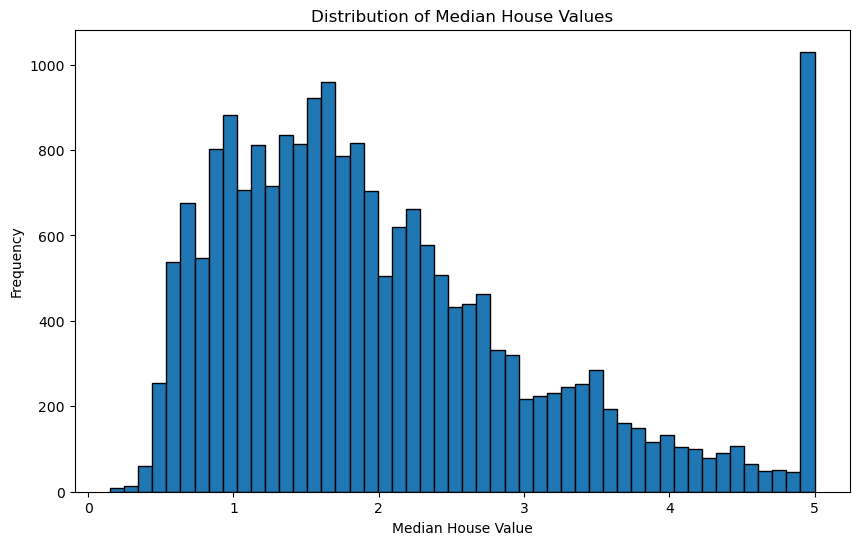

In [ ]:
# Plot a histogram of the MedianHouseValue
plt.figure(figsize=(10, 6))
plt.hist(housing.target, bins=50, edgecolor='black')
plt.title('Distribution of Median House Values')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import pandas as pd
# Create a DataFrame with feature names as columns
train_df = pd.DataFrame(X_train_scaled, columns=housing.feature_names)

# Add the target variable as a new column
train_df['MedianHouseValue'] = y_train

# Create a DataFrame with feature names as columns
test_df = pd.DataFrame(X_test_scaled, columns=housing.feature_names)

# Add the target variable as a new column
test_df['MedianHouseValue'] = y_test

## Saving the data in Watson Studio.

Once these are saved, you can download them from the project to reupload in OpenScale

In [ ]:
train_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,-0.326196,0.348490,-0.174916,-0.208365,0.768276,0.051376,-1.372811,1.272587,1.030
1,-0.035843,1.618118,-0.402835,-0.128530,-0.098901,-0.117362,-0.876696,0.709162,3.821
2,0.144701,-1.952710,0.088216,-0.257538,-0.449818,-0.032280,-0.460146,-0.447603,1.726
3,-1.017864,0.586545,-0.600015,-0.145156,-0.007434,0.077507,-1.382172,1.232698,0.934
4,-0.171488,1.142008,0.349007,0.086624,-0.485877,-0.068832,0.532084,-0.108551,0.965


In [ ]:
from project_lib import Project
project = Project.access()

project.save_data('test_dataset_housing.csv', test_df.to_csv(index=False),overwrite=True)
project.save_data('training_dataset_housing.csv', train_df.to_csv(index=False),overwrite=True)

{'file_name': 'training_dataset_housing.csv',
 'message': 'File saved to project storage.',
 'asset_id': '8dc01a42-fbff-4cd0-a03d-601c7053a8f5'}

## Deploying the Model to a Space

In [ ]:
PROJECT_ID = "bee9437b-dbf7-4fd2-9bf8-218968c5ca3f" # YOUR_PROJECT_ID

**TODO:** 
1. Insert the Cloud Pak for Data base URL, your username, and your password into the code block below 
2. In a new tab, open CP4D and get your API Key by clicking on your profile logo in the top right corner > Profile and Settings > API Key in the top right corner > Generate New Key

In [ ]:
from ibm_watson_machine_learning import APIClient

# CPD_URL EXAMPLE: https://cpd-ibm-cpd-operands.apps.cluster.sample.test.ic1.ibm/
CPD_URL = "<Your Current CPD URL from beginning to before projects>"
CPD_USERNAME = 'Ashwin.Pothukuchi@ibm.com'
CPD_API_KEY="<Your API Key>"
WOS_SERVICE_INSTANCE_ID = "00000000-0000-0000-0000-000000000000" # If None, default instance would be used
WML_CREDENTIALS = {
    "url": CPD_URL,
    "username": CPD_USERNAME,
    "apikey" : CPD_API_KEY,
    "instance_id": 'openshift',
    "disable_ssl_verification": True
}

wml_client = APIClient(WML_CREDENTIALS)

In [ ]:
wml_client.set.default_project(PROJECT_ID)

'SUCCESS'

## Track the relevant metadata such as feature name and type

In [ ]:
fields=housing.feature_names
fields

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [ ]:
metadata_dict = {'target_col' : 'MedianHouseValue', 'fields':fields, 'name': 'HomePricing'}

In [ ]:
field_list = [ {"name": str(x), "nullable": True, "metadata": {}, "type": "double"} for x in fields]
training_data_references = [
                {
                    "id": "HomePricing",
                    "type": "container",
                    "connection": {},
                    "location": {
                        "path": "training_dataset_housing.csv"
                    },
                    "schema": {
                        "id": "training_schema",
                        "fields": field_list
                    }
                }
            ]

In [ ]:
software_spec_uid = wml_client.software_specifications.get_id_by_name("runtime-24.1-py3.11")
print("Software Specification ID: {}".format(software_spec_uid))

model_props = {
    wml_client._models.ConfigurationMetaNames.NAME:"{}".format("HomePricing_LR"),
    wml_client._models.ConfigurationMetaNames.TYPE: "scikit-learn_1.3",
    wml_client._models.ConfigurationMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    wml_client._models.ConfigurationMetaNames.TRAINING_DATA_REFERENCES: training_data_references,
    wml_client._models.ConfigurationMetaNames.LABEL_FIELD: "HomePricing_LR",
    wml_client._models.ConfigurationMetaNames.CUSTOM: metadata_dict
}

Software Specification ID: 45f12dfe-aa78-5b8d-9f38-0ee223c47309


In [ ]:
print("Storing model...")
published_model_details = wml_client.repository.store_model(
    model=lr_model,
    meta_props=model_props,
    training_target=y_train,
    training_data=X_train_scaled)
model_uid = wml_client.repository.get_model_id(published_model_details)

print("Done")
print("Model ID: {}".format(model_uid))

Storing model...
Done
Model ID: 8fca7cce-8658-49ab-833a-e9884e74720b


Please re-run the cell block above if you see an error.

In [ ]:
wml_client.spaces.list(limit=10)

------------------------------------  -------------------------  ------------------------
ID                                    NAME                       CREATED
4e281ae7-53f7-4541-a1ea-955dd88d18e6  Home Pricing Model         2024-10-21T21:41:01.351Z
ace87967-c453-4bbc-ad79-e8cb3682f1c2  Lab Deployment Space       2024-10-18T13:35:48.606Z
ee8b429b-5abb-4a69-92e4-0b3e53b51e80  HR Recruitment Deployment  2024-09-12T17:17:09.363Z
------------------------------------  -------------------------  ------------------------


,ID,NAME,CREATED
0,4e281ae7-53f7-4541-a1ea-955dd88d18e6,Home Pricing Model,2024-10-21T21:41:01.351Z
1,ace87967-c453-4bbc-ad79-e8cb3682f1c2,Lab Deployment Space,2024-10-18T13:35:48.606Z
2,ee8b429b-5abb-4a69-92e4-0b3e53b51e80,HR Recruitment Deployment,2024-09-12T17:17:09.363Z


**TODO**: Find the Space ID corresponding to the Name you had created in Step 2. 

In [ ]:
# TODO: CHANGE THIS SPACE ID TO THE ONE CORRESPONDING TO THE DEPLOYMENT SPACE YOU CREATED!
space_id = '4e281ae7-53f7-4541-a1ea-955dd88d18e6'

In [ ]:
wml_client.set.default_space(space_id)

Unsetting the project_id ...


'SUCCESS'

In [ ]:
models_details = wml_client.repository.list_models()

------------------------------------  --------------  ------------------------  ----------------  ----------  ----------------
ID                                    NAME            CREATED                   TYPE              SPEC_STATE  SPEC_REPLACEMENT
e843dc71-6b71-4a87-8f81-38096e707d31  HomePricing_RF  2024-10-21T22:10:28.002Z  scikit-learn_1.3  supported
b4c9eb68-d973-4d8d-a3fa-5f9d905f8f0c  HomePricing     2024-10-21T22:08:17.002Z  scikit-learn_1.3  supported
e2a016e9-8181-4b56-9087-c0576fefb3b9  HomePricing     2024-10-21T21:53:06.002Z  scikit-learn_1.3  supported
------------------------------------  --------------  ------------------------  ----------------  ----------  ----------------


In [ ]:
metadata = {
    wml_client.deployments.ConfigurationMetaNames.NAME: "Home Pricing Linear Regression Model",
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = wml_client.deployments.create(model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '8fca7cce-8658-49ab-833a-e9884e74720b' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='0f170a20-257c-4a4f-b272-1a9aeb9d1e67'
------------------------------------------------------------------------------------------------




## Repeat for Random Forest Model

In [ ]:
software_spec_uid = wml_client.software_specifications.get_id_by_name("runtime-24.1-py3.11")
print("Software Specification ID: {}".format(software_spec_uid))

model_props = {
    wml_client._models.ConfigurationMetaNames.NAME:"{}".format("HomePricing_RF"),
    wml_client._models.ConfigurationMetaNames.TYPE: "scikit-learn_1.3",
    wml_client._models.ConfigurationMetaNames.SOFTWARE_SPEC_UID: software_spec_uid,
    wml_client._models.ConfigurationMetaNames.TRAINING_DATA_REFERENCES: training_data_references,
    wml_client._models.ConfigurationMetaNames.LABEL_FIELD: "HomePricing_RF",
    wml_client._models.ConfigurationMetaNames.CUSTOM: metadata_dict
}

Software Specification ID: 45f12dfe-aa78-5b8d-9f38-0ee223c47309


In [ ]:
print("Storing model...")
published_model_details = wml_client.repository.store_model(
    model=rf_model,
    meta_props=model_props,
    training_target=y_train,
    training_data=X_train)
model_uid = wml_client.repository.get_model_id(published_model_details)

print("Done")
print("Model ID: {}".format(model_uid))

Storing model...
Done
Model ID: e843dc71-6b71-4a87-8f81-38096e707d31


In [ ]:
wml_client.spaces.list(limit=10)

------------------------------------  -------------------------  ------------------------
ID                                    NAME                       CREATED
4e281ae7-53f7-4541-a1ea-955dd88d18e6  Home Pricing Model         2024-10-21T21:41:01.351Z
ace87967-c453-4bbc-ad79-e8cb3682f1c2  Lab Deployment Space       2024-10-18T13:35:48.606Z
ee8b429b-5abb-4a69-92e4-0b3e53b51e80  HR Recruitment Deployment  2024-09-12T17:17:09.363Z
------------------------------------  -------------------------  ------------------------


,ID,NAME,CREATED
0,4e281ae7-53f7-4541-a1ea-955dd88d18e6,Home Pricing Model,2024-10-21T21:41:01.351Z
1,ace87967-c453-4bbc-ad79-e8cb3682f1c2,Lab Deployment Space,2024-10-18T13:35:48.606Z
2,ee8b429b-5abb-4a69-92e4-0b3e53b51e80,HR Recruitment Deployment,2024-09-12T17:17:09.363Z


In [ ]:
space_id = '4e281ae7-53f7-4541-a1ea-955dd88d18e6'

In [ ]:
wml_client.set.default_space(space_id)

'SUCCESS'

In [ ]:
models_details = wml_client.repository.list_models()

------------------------------------  --------------  ------------------------  ----------------  ----------  ----------------
ID                                    NAME            CREATED                   TYPE              SPEC_STATE  SPEC_REPLACEMENT
e843dc71-6b71-4a87-8f81-38096e707d31  HomePricing_RF  2024-10-21T22:10:28.002Z  scikit-learn_1.3  supported
b4c9eb68-d973-4d8d-a3fa-5f9d905f8f0c  HomePricing     2024-10-21T22:08:17.002Z  scikit-learn_1.3  supported
e2a016e9-8181-4b56-9087-c0576fefb3b9  HomePricing     2024-10-21T21:53:06.002Z  scikit-learn_1.3  supported
------------------------------------  --------------  ------------------------  ----------------  ----------  ----------------


In [ ]:
metadata = {
    wml_client.deployments.ConfigurationMetaNames.NAME: "Home Pricing Random Forest Model",
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = wml_client.deployments.create(model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: 'e843dc71-6b71-4a87-8f81-38096e707d31' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='48b3259f-b746-407f-8bcc-3ffbb2d7a2f2'
------------------------------------------------------------------------------------------------


